## 1. Camera calibration and image undistortion

In [156]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


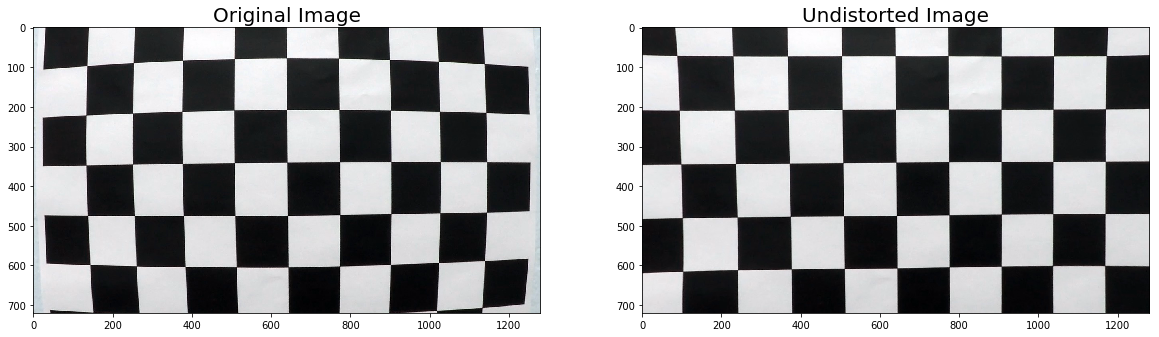

In [157]:
example_img = cv2.imread("camera_cal/calibration1.jpg")
ret, mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1], None, None)
dst = cv2.undistort(example_img,mtx,dist,None,mtx)

def plt_two_images(img1,img2,name1="image1",name2="image2"):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(name1, fontsize=20)
    ax2.imshow(img2)
    ax2.set_title(name2, fontsize=20)
plt_two_images(example_img, dst,"Original Image","Undistorted Image")

## 2. Test images

### 2.1 An example of undistorted image

In [237]:
def undistort(img):
    return cv2.undistort(img,mtx,dist,None,mtx)
img = mpimg.imread("test_images/test6.jpg")
dst = undistort(img)
plt_two_images(img,dst,"Original Image","Undistorted Image")

### 2.2 Binarize image

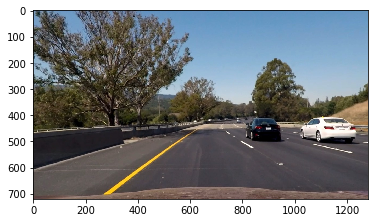

In [238]:
#image = mpimg.imread('test_images/test5.jpg')
image = dst
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(image)
plt.show()
plt.imshow(binary*255, cmap="gray", vmin=0, vmax=255)
plt.show()

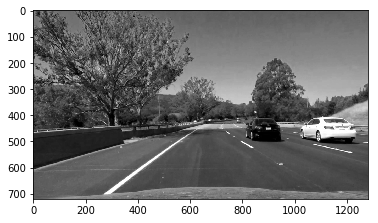

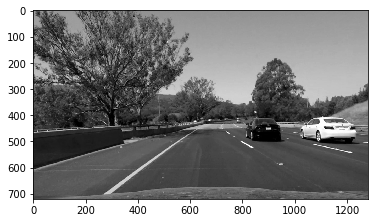

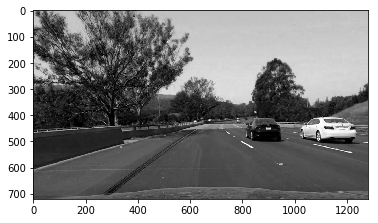

In [239]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
plt.imshow(R,cmap="gray")
plt.show()
plt.imshow(G,cmap="gray")
plt.show()
plt.imshow(B,cmap="gray")
plt.show()

In [240]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(binary,cmap="gray")
plt.show()

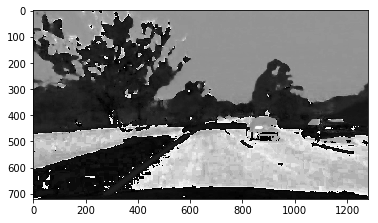

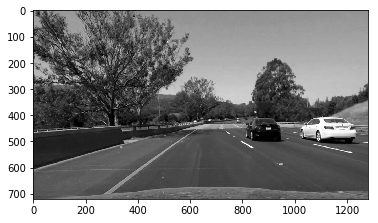

In [241]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
plt.imshow(H,cmap="gray")
plt.show()
plt.imshow(L,cmap="gray")
plt.show()
plt.imshow(S,cmap="gray")
plt.show()

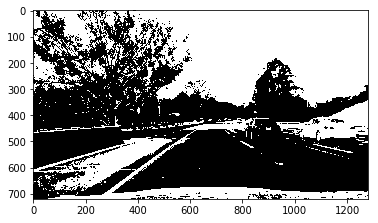

In [242]:
thresh = (90, 255)
binary = np.zeros_like(L)
binary[(L > thresh[0]) & (L <= thresh[1])] = 1
plt.imshow(binary,cmap="gray")
plt.show()

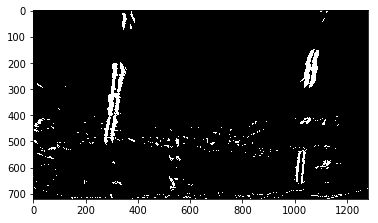

In [243]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel 
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # dirivative in y
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradient
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
test_img = mpimg.imread("output_images/wraped_img5.jpg")
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh=(10, 100))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 100))
mag_binary = mag_thresh(test_img, sobel_kernel=ksize, mag_thresh=(20, 200))
dir_binary = dir_threshold(test_img, sobel_kernel=ksize, thresh=(0.7, 1.3))


combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
#combined[((gradx == 1)) | ( & (dir_binary == 1))] = 255
combined[((gradx == 1)) & (mag_binary == 1) ] = 255
# Plotting thresholded images

plt.imshow(combined, cmap='gray')
plt.show()

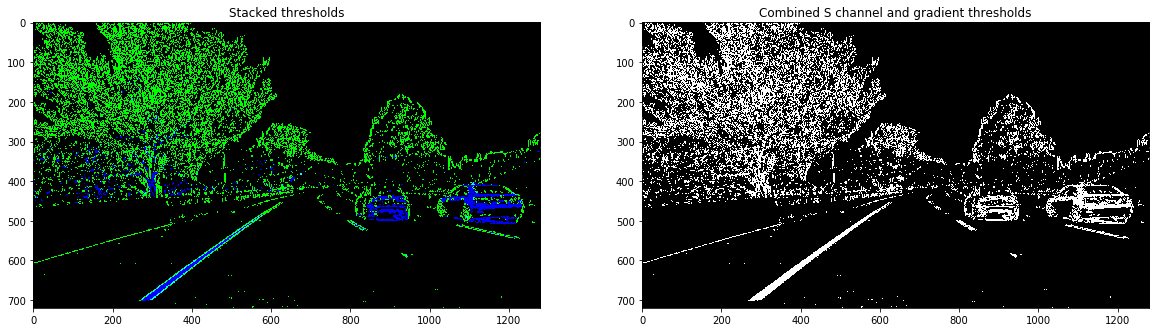

In [244]:
def gradient_channel_combined(img):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold s channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    #Threshold l channel
    l_thresh_min = 40
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, color_binary

binary_lane, color_lane = gradient_channel_combined(image)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_lane)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(binary_lane, cmap='gray')
plt.show()

In [578]:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask


def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask
def hsv_lane(image):    
    yellow_mask = select_yellow(image)
    white_mask = select_white(image)
    combined_binary = np.zeros_like(yellow_mask)
    combined_binary[(yellow_mask>0) | (white_mask>0)] = 1
    return combined_binary


###  2.3 View transform

In [579]:
def warp(img,src,dst):
    img_size = img.shape[1::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

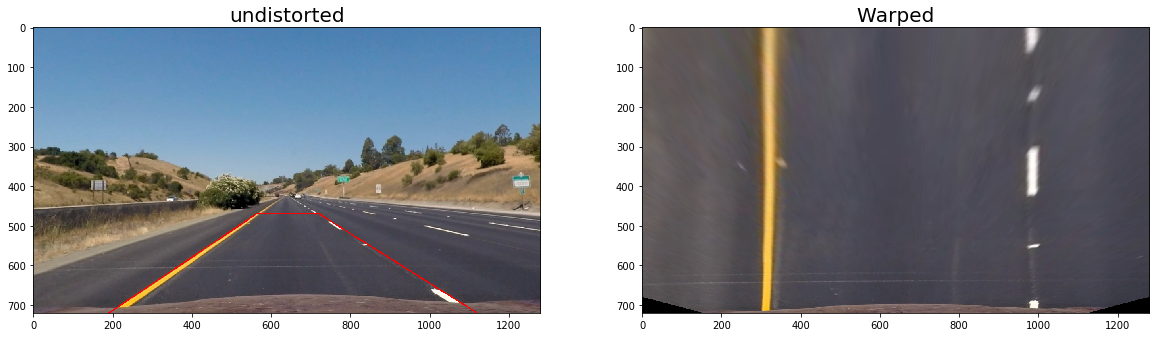

In [580]:
img = mpimg.imread("test_images/straight_lines1.jpg")
undist = undistort(img)
#Source coordinates
src = np.float32(
[[563,470],
[720,470],
[1120,720],
[190,720]])
#Destinate corrdinates
dst = np.float32([[300,100],[1000,100],[1000,720],[300,720]])

corners=[]
for ind,c in enumerate(src):
    corners.append(tuple(src[ind]))

warped,M,Minv = warp(undist,src,dst)   
cv2.line(undist, corners[0],corners[1],color=[255,0,0],thickness=2)
cv2.line(undist, corners[1],corners[2],color=[255,0,0],thickness=2)
cv2.line(undist, corners[2],corners[3],color=[255,0,0],thickness=2)
cv2.line(undist, corners[3],corners[0],color=[255,0,0],thickness=2)


plt_two_images(undist,warped,"undistorted","Warped")

### 2.4 Detect lane lines pixels and fit with a polynomial

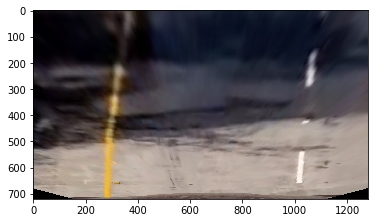

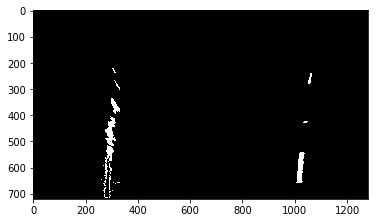

In [581]:
img = mpimg.imread("test_images/test5.jpg")
undist = undistort(img)
warped,M,Minv = warp(undist,src,dst)
#binary_warped, color_warped = gradient_channel_combined(warped)
#binary_warped[(select_yellow(warped)==1) | (select_white(warped) ==1)] = 1
#binary_warped = abs_sobel_thresh(warped, orient='x', sobel_k
binary_warped = hsv_lane(warped)
plt.imshow(warped)
plt.show()
plt.imshow(binary_warped, cmap="gray")
plt.show()

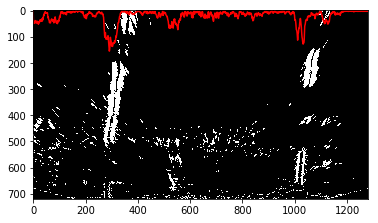

In [582]:

def find_lane_points(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
#    binary_warped, color_warped = gradient_channel_combined(warped)
    #binary_warped = mpimg.imread('warped-example.jpg')
    #binary_warped = abs_sobel_thresh(warped, orient='x', sobel_kernel=25, thresh=(10, 100))
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    return binary_warped,leftx,lefty,rightx,righty,histogram

binary_warped = abs_sobel_thresh(warped, orient='x', sobel_kernel=25, thresh=(10, 100))
binary_warped,leftx,lefty,rightx,righty, histogram = find_lane_points(binary_warped)
plt.imshow(binary_warped, cmap="gray")
plt.plot(histogram, color="red")  




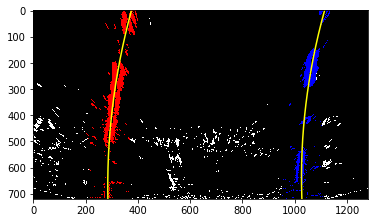

In [583]:

# Fit a second order polynomial to each

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
out_img[lefty,leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()

In [584]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left curve:",left_curverad, "Right curve:",right_curverad)

Left curve: 2727.88377027 Right curve: 2544.43831704


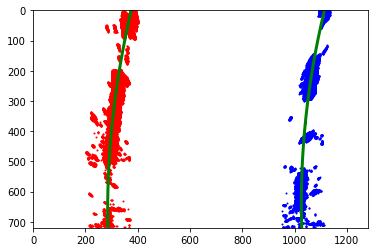

In [587]:
plt.plot(leftx, lefty, 'o', color='red', markersize=1)
plt.plot(rightx, righty, 'o', color='blue', markersize=1)
plt.xlim(0, 1280)
plt.ylim(0, 720)


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [588]:
#assume the lane width is 3.7 meter
lane_width = 3.7
pos = undist.shape[1] / 2.0
middle = (right_fitx[-1] + left_fitx[-1]) / 2.0
offset = (pos - middle) * 3.7 / (middle *2)
print(offset)


-0.0461472328825


### 2.5 Project the detected lane area to the road

Left curve: 2727.88 m Right curve: 2544.44 m
Position : 0.05 m left of center


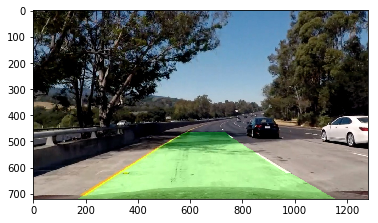

In [590]:
def draw_lane(binary_warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = draw_lane(binary_warped, undist,left_fitx,right_fitx,ploty)
plt.imshow(result)
print("Left curve: %.2f m"%left_curverad, "Right curve: %.2f m"%right_curverad)
print('Position : %.2f m %s of center'%(abs(offset), 'left' if offset < 0 else 'right'))



## 3 Process Video

In [591]:

def put_text(image,radius,offset):
    
    cv2.putText(image,'Radius of curve: %.0f m'%radius,(50,80), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Vehicle position : %.2f m'%offset,(50,110), \
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return image

first_frame = True
left_fit=[]
right_fit=[]
def process_video(image):
    # Distortion correction
    undist = undistort(image)
    
    # View transformation
    warped = warped,M,Minv = warp(undist,src,dst)
    
    # Binarize warped image    
    #binary_warped = abs_sobel_thresh(warped, orient='x', sobel_kernel=15, thresh=(10, 255))
    
    #binary_warped, color_warped = gradient_channel_combined(warped)
    binary_warped = hsv_lane(warped)
    global first_frame,left_fit,right_fit

    # Find lane points
    if first_frame:
        first_frame = False
        binary_warped,leftx,lefty,rightx,righty, histogram = find_lane_points(binary_warped)
    else:
        binary_warped,leftx,lefty,rightx,righty = next_frame(binary_warped,left_fit,right_fit)
    # Fit a second order polynomial with detected lane points
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[lefty,leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Calculate the position of the car
    lane_width = 3.7
    pos = undist.shape[1] / 2.0
    middle = (right_fitx[-1] + left_fitx[-1]) / 2.0
    offset = (pos - middle) * 3.7 / (middle *2)
    
    # Calculate the radius of curve
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    radius = (right_curverad+left_curverad)/2
    
    # Draw the lane area on origianl the image
    result = draw_lane(binary_warped, undist,left_fitx, right_fitx,ploty)
    # Add information texts to the result image
    put_text(result, radius, offset)
    

    return result
    

In [592]:
def next_frame(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return binary_warped,leftx,lefty,rightx,righty

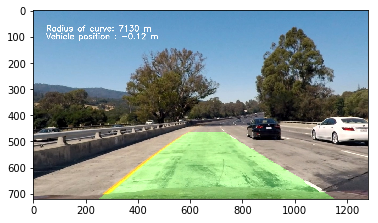

In [593]:
img = mpimg.imread("test_images/test1.jpg")
plt.imshow(process_video(img))
plt.show()

In [594]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:43<00:00, 12.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 45s, sys: 1.83 s, total: 8min 47s
Wall time: 1min 44s
